# **Preparación Del Entorno**

In [1]:
# Descargar dataset
!kaggle datasets download uraninjo/augmented-alzheimer-mri-dataset

Dataset URL: https://www.kaggle.com/datasets/uraninjo/augmented-alzheimer-mri-dataset
License(s): GNU Lesser General Public License 3.0
 99% 376M/380M [00:12<00:00, 35.2MB/s]
100% 380M/380M [00:12<00:00, 31.5MB/s]


In [2]:
# Descomprimir archivo
!unzip -q /content/augmented-alzheimer-mri-dataset.zip -d /content/dataset

In [3]:
# Importar librerías necesarias
import pandas as pd
import numpy as np
import keras

# Silenciar warnings
import warnings
warnings.filterwarnings(action="ignore")
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import TensorBoard,EarlyStopping

import sklearn.metrics as metrics
from keras.callbacks import LearningRateScheduler
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.95 ** x, verbose=0)

In [4]:
import os # Manipulación de directorios
import pandas as pd # Manipulación de datos

# Ruta a los directorios
MildDemented_dir = r'/content/dataset/AugmentedAlzheimerDataset/MildDemented'
ModerateDemented_dir = r'/content/dataset/AugmentedAlzheimerDataset/ModerateDemented'
NonDemented_dir = r'/content/dataset/AugmentedAlzheimerDataset/NonDemented'
VeryMildDemented_dir = r'/content/dataset/AugmentedAlzheimerDataset/VeryMildDemented'

filepaths = []
labels = []
dict_list = [MildDemented_dir, ModerateDemented_dir, NonDemented_dir, VeryMildDemented_dir]
class_labels = ['Demencia Leve', 'Demencia Moderada', 'Sin Demencia', 'Demencia Muy Leve']

for i, j in enumerate(dict_list):
    flist = os.listdir(j)
    for f in flist:
        fpath = os.path.join(j, f)
        filepaths.append(fpath)
        labels.append(class_labels[i])

Fseries = pd.Series(filepaths, name="filepaths")
Lseries = pd.Series(labels, name="labels")
Alzheimer_data = pd.concat([Fseries, Lseries], axis=1)
Alzheimer_df = pd.DataFrame(Alzheimer_data)
print(Alzheimer_df.head())
print(Alzheimer_df["labels"].value_counts())

                                           filepaths         labels
0  /content/dataset/AugmentedAlzheimerDataset/Mil...  Demencia Leve
1  /content/dataset/AugmentedAlzheimerDataset/Mil...  Demencia Leve
2  /content/dataset/AugmentedAlzheimerDataset/Mil...  Demencia Leve
3  /content/dataset/AugmentedAlzheimerDataset/Mil...  Demencia Leve
4  /content/dataset/AugmentedAlzheimerDataset/Mil...  Demencia Leve
labels
Sin Demencia         9600
Demencia Leve        8960
Demencia Muy Leve    8960
Demencia Moderada    6464
Name: count, dtype: int64


In [5]:
# Ver forma del dataset
Alzheimer_df.shape

(33984, 2)

In [6]:
# División del conjunto de datos en entrenamiento y prueba
train_images, test_images = train_test_split(Alzheimer_df, test_size=0.3, random_state=42)
train_set, val_set = train_test_split(Alzheimer_df, test_size=0.2, random_state=42)

In [7]:
# Imprimir forma de los conjuntos de datos
print(train_set.shape)
print(test_images.shape)
print(val_set.shape)
print(train_images.shape)

(27187, 2)
(10196, 2)
(6797, 2)
(23788, 2)


In [8]:
image_gen = ImageDataGenerator(preprocessing_function= tf.keras.applications.mobilenet_v2.preprocess_input)
train = image_gen.flow_from_dataframe(
  dataframe= train_set,x_col="filepaths",
  y_col="labels",
  target_size=(244,244),
  color_mode='rgb',
  class_mode="categorical", # Usado para  modelo sencuencial
  batch_size=32,
  shuffle=False  # No barajar los datos
)
test = image_gen.flow_from_dataframe(
  dataframe= test_images,x_col="filepaths", y_col="labels",
  target_size=(244,244),
  color_mode='rgb',
  class_mode="categorical",
  batch_size=32,
  shuffle= False
)
val = image_gen.flow_from_dataframe(

  dataframe= val_set,x_col="filepaths",
  y_col="labels",
  target_size=(244,244),
  color_mode= 'rgb',
  class_mode="categorical",
  batch_size=32,
  shuffle=False
)

Found 27187 validated image filenames belonging to 4 classes.
Found 10196 validated image filenames belonging to 4 classes.
Found 6797 validated image filenames belonging to 4 classes.


In [9]:
classes=list(train.class_indices.keys())
print (classes)

['Demencia Leve', 'Demencia Moderada', 'Demencia Muy Leve', 'Sin Demencia']


In [10]:
def show_knee_images(image_gen):
    test_dict = test.class_indices
    classes = list(test_dict.keys())
    images, labels=next(image_gen) # Obtener un lote de muestra del generador
    plt.figure(figsize=(20,20))
    length = len(labels)
    if length<25:
        r=length
    else:
        r=25
    for i in range(r):
        plt.subplot(5,5,i+1)
        image=(images[i]+1)/2 # Escalar las imagenes entre 0 y 1
        plt.imshow(image)
        index=np.argmax(labels[i])
        class_name=classes[index]
        plt.title(class_name,fontsize=16)
        plt.axis('on')

    plt.tight_layout()
    plt.show()

# **Análisis Exploratorio de Datos (EDA)**

In [11]:
# Importar la librería fm de matplotlib
from matplotlib import font_manager as fm

# Configurar el estilo de los gráficos ggplot
plt.style.use('ggplot')

# Ruta a la fuente personalizada
font_path = '/content/KellySlab-Regular.ttf'  # Rura a la fuente personalizada

# Registrar la fuente en matplotlib
font_prop = fm.FontProperties(fname=font_path)
fm.fontManager.addfont(font_path)  # Registrar la fuente en el gestor de fuentes

# Configurar como fuente predeterminada para todos los textos (títulos, etiquetas y números)
plt.rcParams['font.family'] = font_prop.get_name()

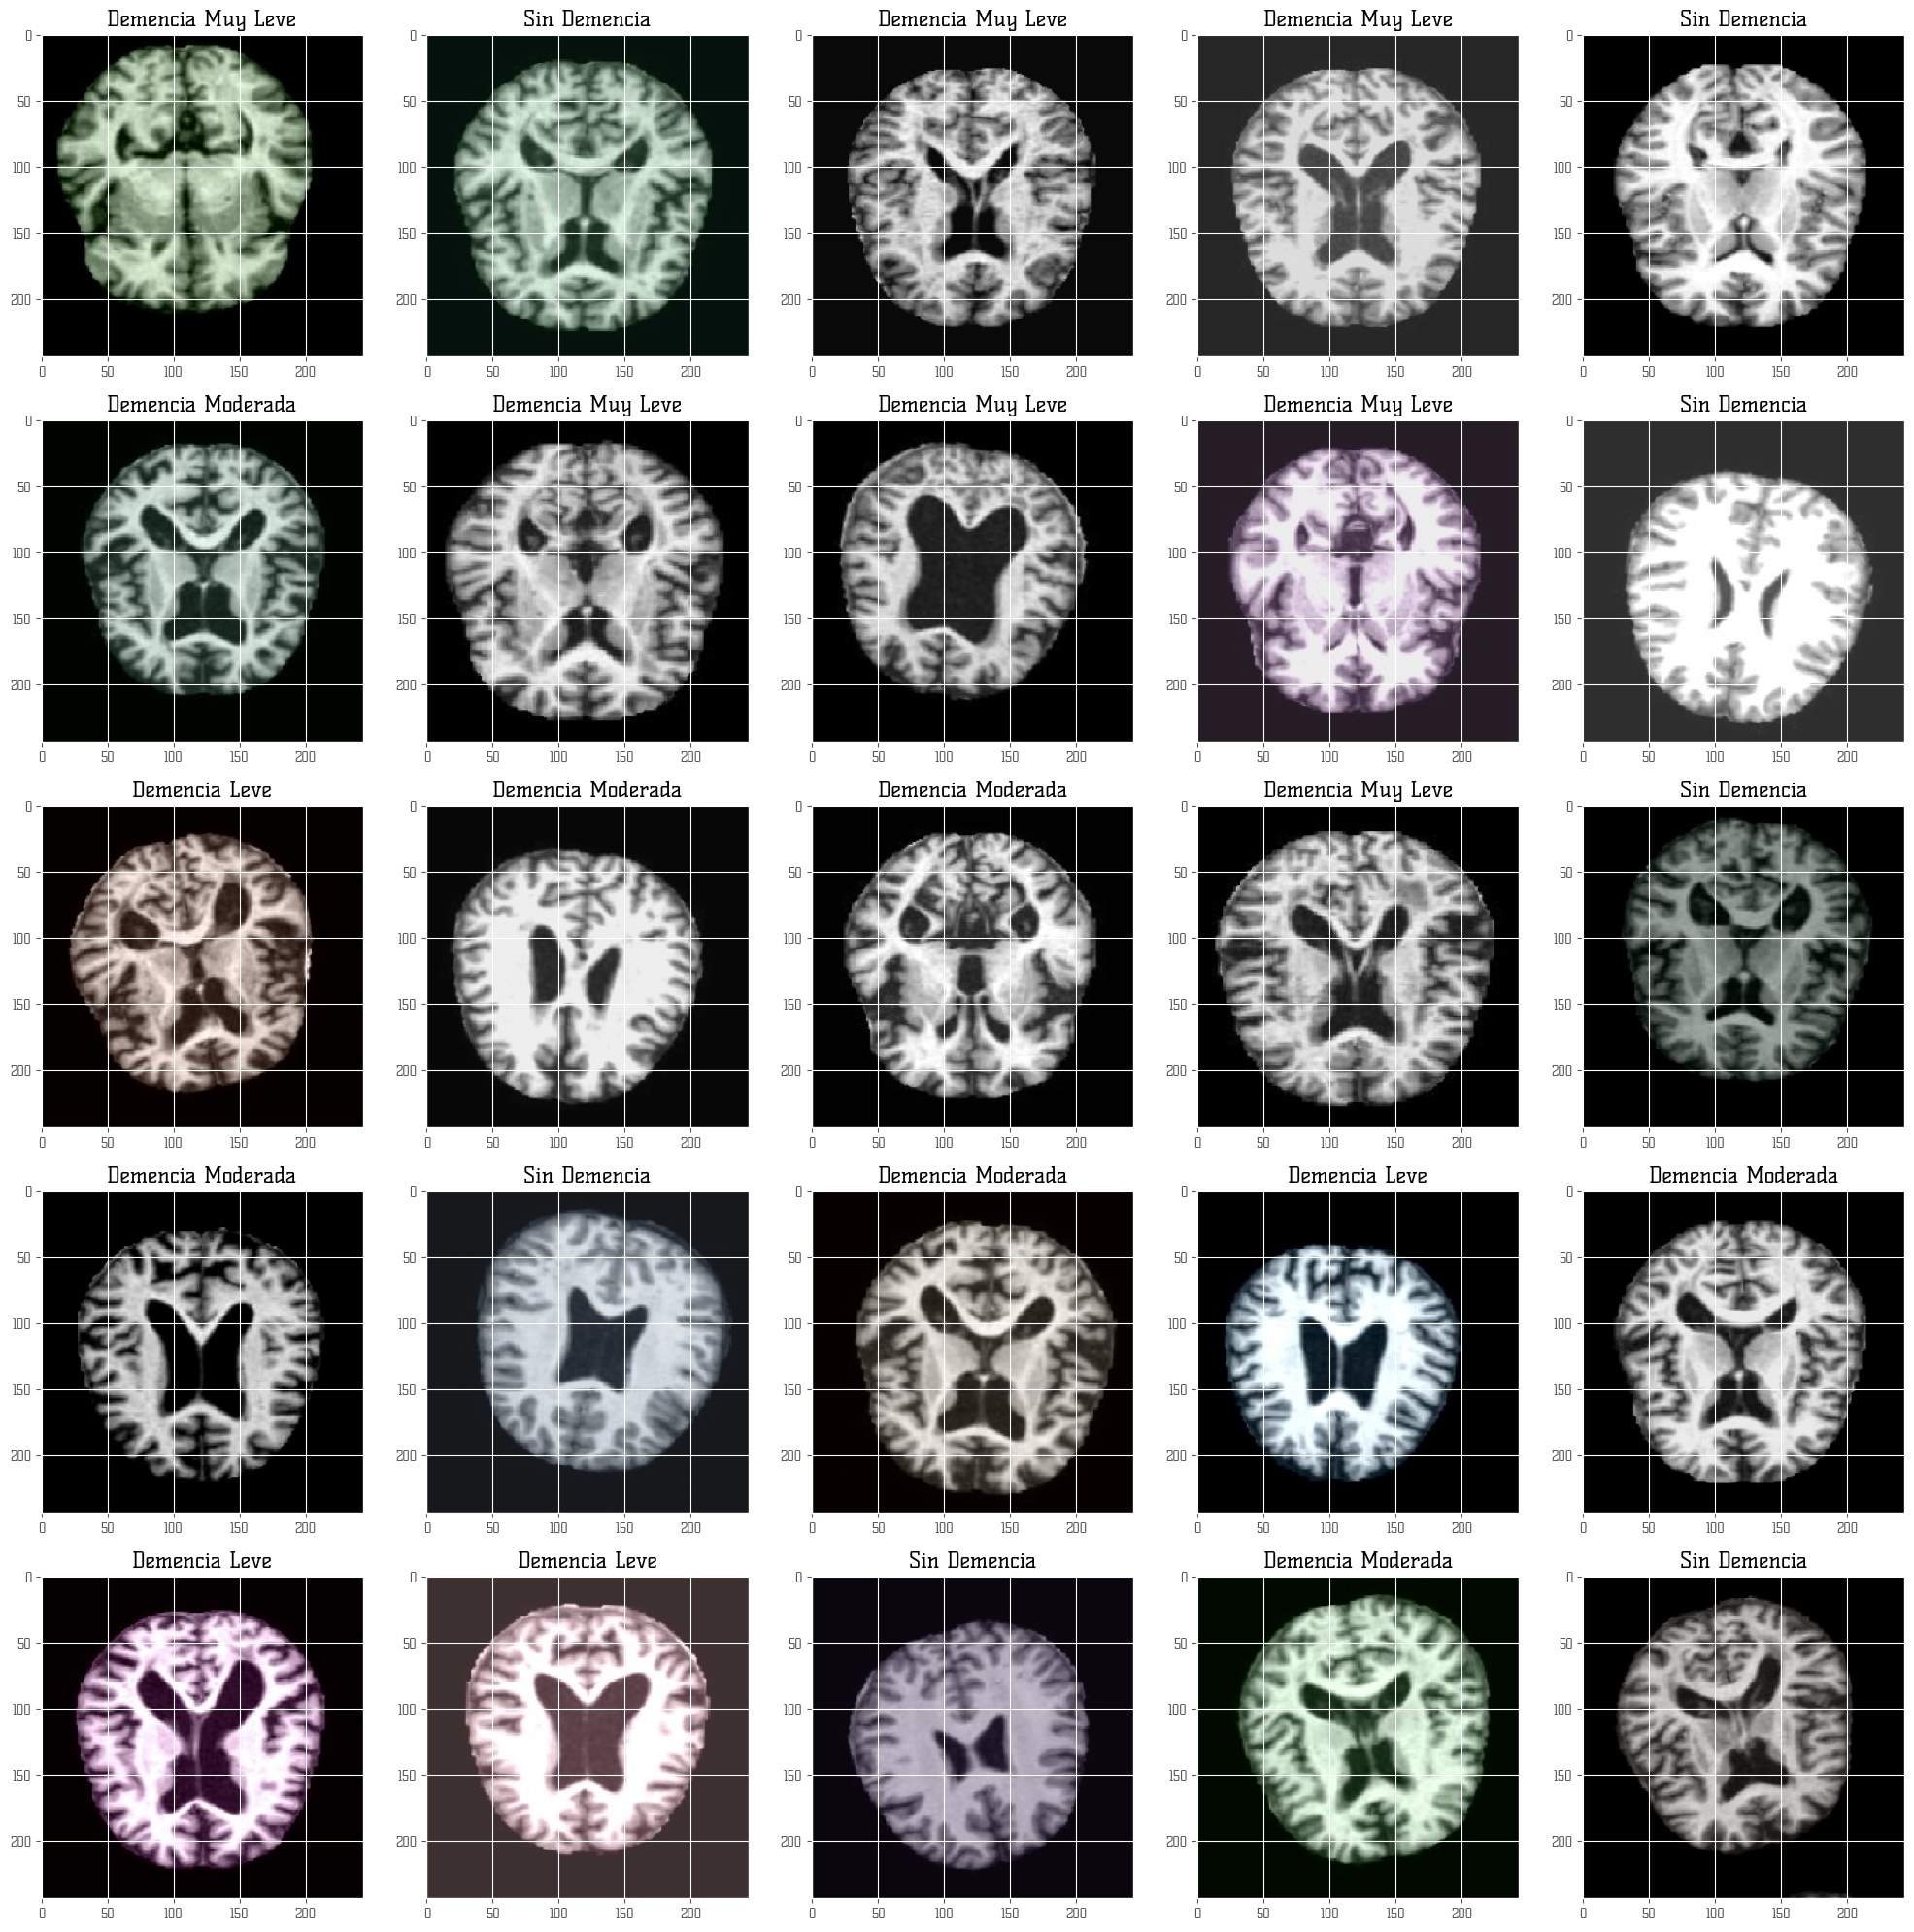

In [ ]:
show_knee_images(train)

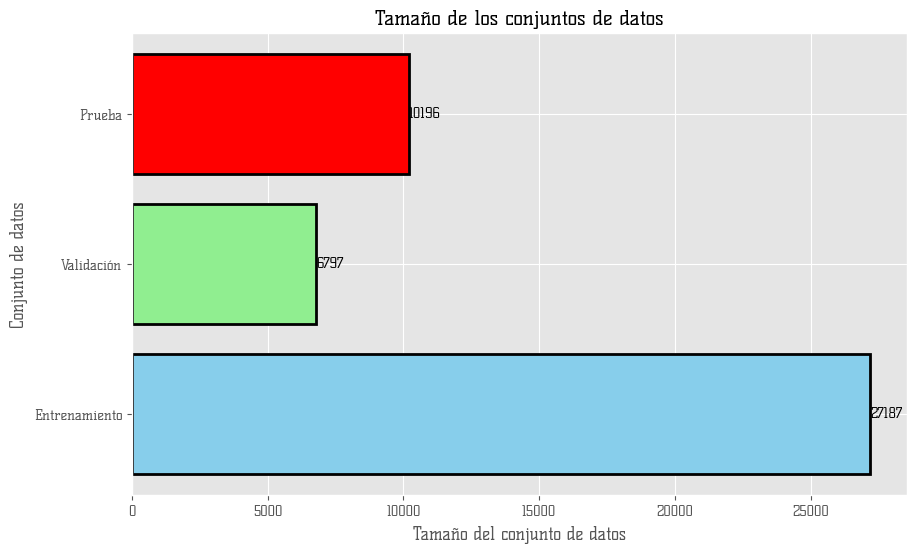

In [ ]:
# Gráfico de barras horizontal sobre el tamaño de los conjuntos

import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# Datos para el gráfico
dataset_sizes = {
    'Entrenamiento': train_set.shape[0],
    'Validación': val_set.shape[0],
    'Prueba': test_images.shape[0]
}

# Crear el gráfico de barras horizontal
plt.figure(figsize=(10, 6))
plt.barh(list(dataset_sizes.keys()), list(dataset_sizes.values()), linewidth=2, edgecolor='black', color=['skyblue', 'lightgreen', 'red'])
plt.xlabel('Tamaño del conjunto de datos')
plt.ylabel('Conjunto de datos')
plt.title('Tamaño de los conjuntos de datos')

# Agregar etiquetas de valor a las barras
for i, v in enumerate(dataset_sizes.values()):
    plt.text(v + 10, i, str(v), color='black', va='center')

# Mostrar el gráfico
plt.show()

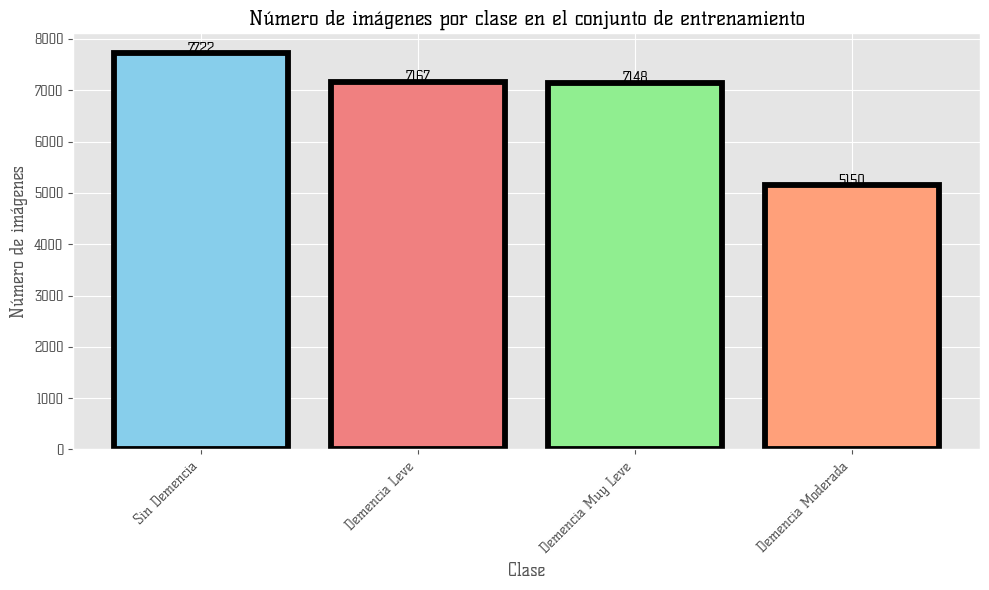

In [ ]:
# Gráfico de barras vertical con el número de imágenes por clase en el conjunto de entrenamiento
train_labels = train_set['labels']
label_counts = train_labels.value_counts()

plt.figure(figsize=(10, 6))
plt.bar(label_counts.index, label_counts.values, color=['skyblue', 'lightcoral', 'lightgreen', 'lightsalmon'], linewidth=4.2, edgecolor='black')
plt.xlabel('Clase')
plt.ylabel('Número de imágenes')
plt.title('Número de imágenes por clase en el conjunto de entrenamiento')
plt.xticks(rotation=45, ha='right')  # Rotar las etiquetas del eje x para una mejor legibilidad

# Agregar etiquetas de valor a las barras
for i, v in enumerate(label_counts.values):
    plt.text(i, v + 10, str(v), color='black', ha='center')

plt.tight_layout()  # Ajustar el diseño para evitar que las etiquetas se superpongan
plt.show()

# **Configuración Del Modelo**

In [12]:
from tensorflow.keras.optimizers import Adamax

img_shape=(244,244,3)
base_model = tf.keras.applications.Xception(include_top= False, weights= "imagenet", input_shape= img_shape, pooling= 'max')

# Para una capa en base_model.layers:
#     layer.trainable = False

model = Sequential([
    base_model,
    Flatten(),
    Dropout(rate= 0.3),
    Dense(128, activation= 'relu'),
    Dropout(rate= 0.25),
    Dense(4, activation= 'softmax')
])

model.compile(Adamax(learning_rate= 0.001),
              loss= 'categorical_crossentropy',
              metrics= ['accuracy'])

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


# **Arquitectura Del Modelo**

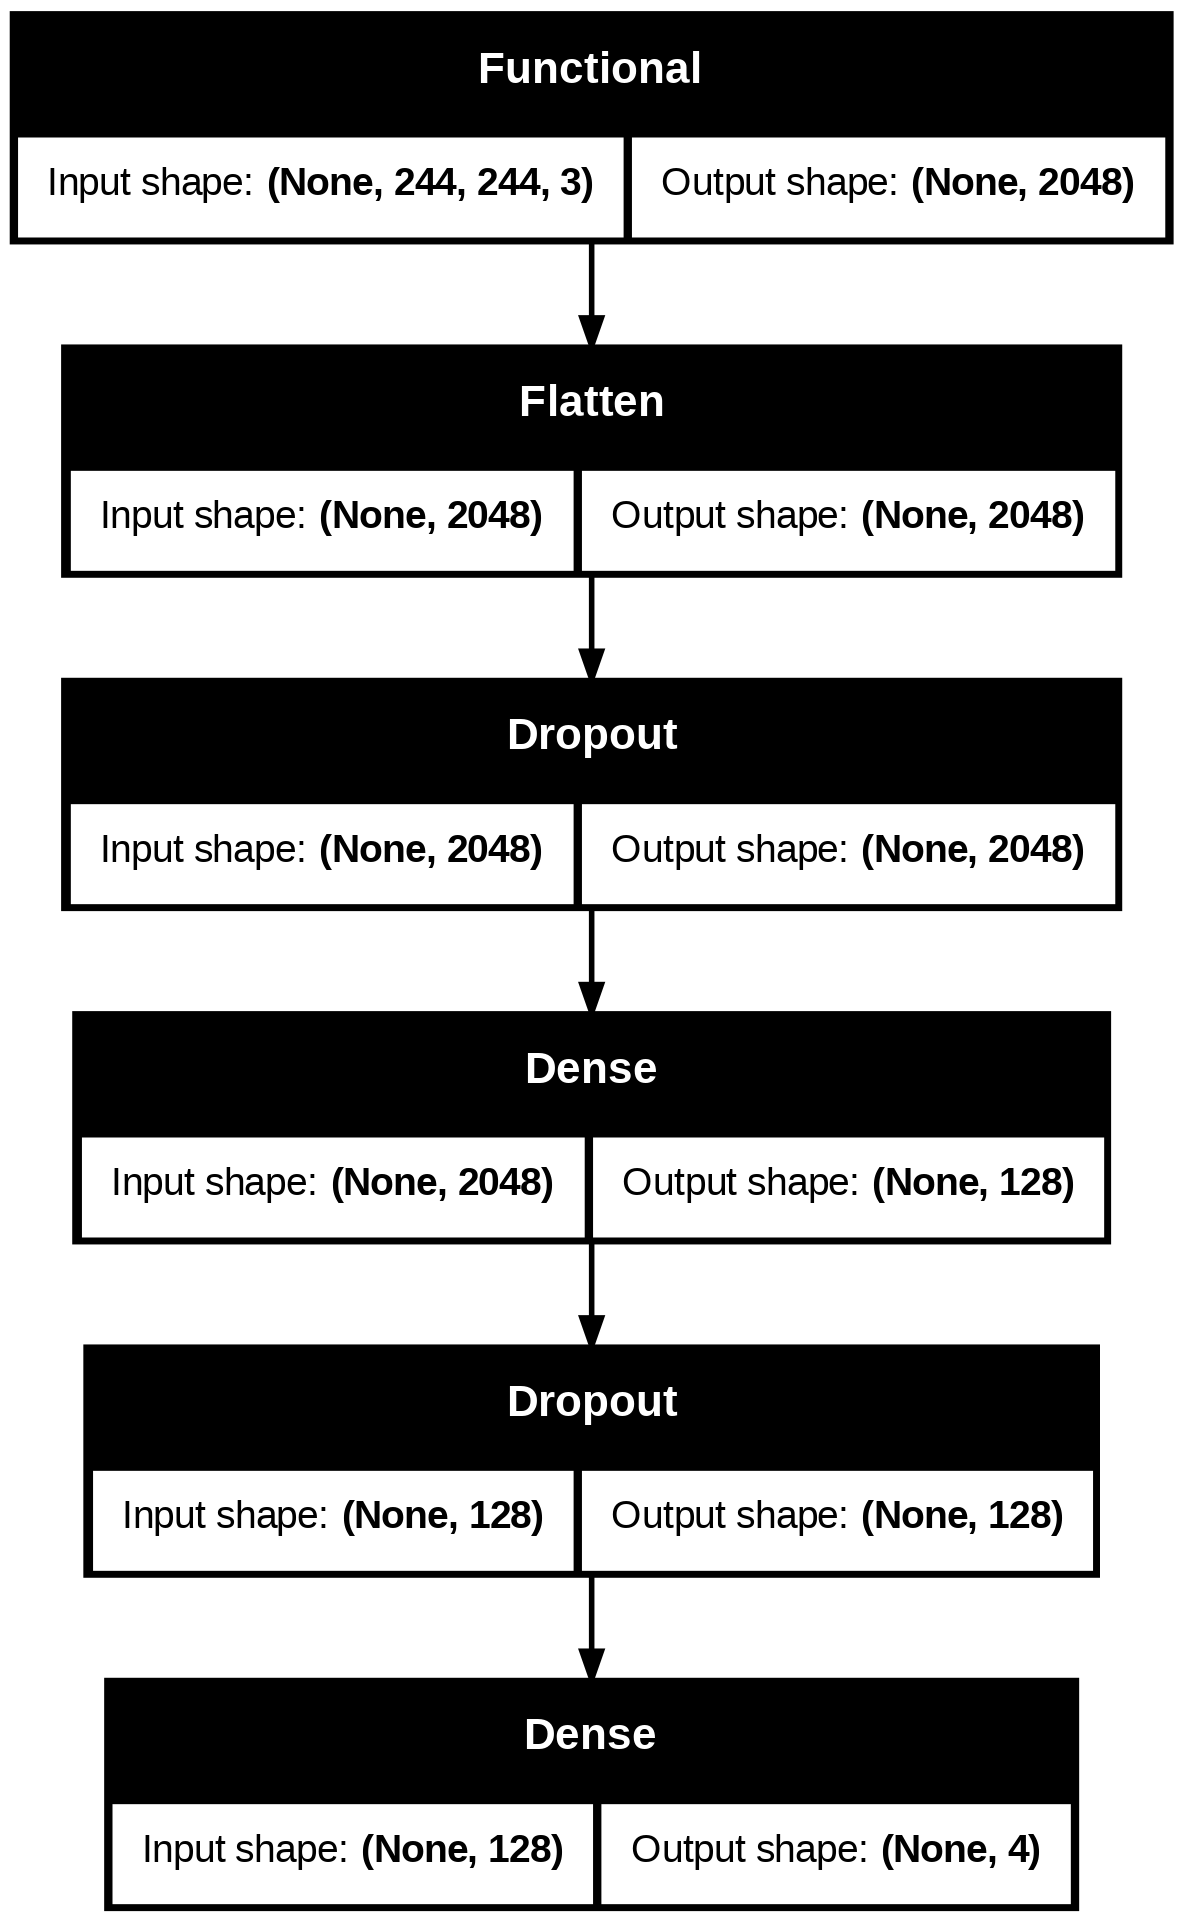

In [ ]:
model.build(input_shape=(None, *img_shape))
tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ xception (Functional)                │ (None, 2048)                │      20,861,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,124,268 (80.58 MB)

 Trainable params: 21,069,740 (80.37 MB)

 Non-trainable params: 54,528 (213.00 KB)

# **Entrenamiento**

In [13]:
history = model.fit(train, epochs=5, validation_data=val, validation_freq=1)

Epoch 1/5
850/850 ━━━━━━━━━━━━━━━━━━━━ 558s 586ms/step - accuracy: 0.6562 - loss: 0.7673 - val_accuracy: 0.8913 - val_loss: 0.2746
Epoch 2/5
850/850 ━━━━━━━━━━━━━━━━━━━━ 488s 544ms/step - accuracy: 0.9693 - loss: 0.0873 - val_accuracy: 0.9426 - val_loss: 0.1841
Epoch 3/5
850/850 ━━━━━━━━━━━━━━━━━━━━ 474s 558ms/step - accuracy: 0.9887 - loss: 0.0328 - val_accuracy: 0.9821 - val_loss: 0.0616
Epoch 4/5
850/850 ━━━━━━━━━━━━━━━━━━━━ 463s 544ms/step - accuracy: 0.9926 - loss: 0.0240 - val_accuracy: 0.9359 - val_loss: 0.2023
Epoch 5/5
850/850 ━━━━━━━━━━━━━━━━━━━━ 503s 545ms/step - accuracy: 0.9938 - loss: 0.0179 - val_accuracy: 0.9934 - val_loss: 0.0243


In [14]:
model.evaluate(test, verbose=1)

319/319 ━━━━━━━━━━━━━━━━━━━━ 53s 167ms/step - accuracy: 0.9935 - loss: 0.0218


[0.01664968766272068, 0.9954884052276611]

# **Guardar Modelo**

In [15]:
model.save("Alzheimer_Classification_Model_99.5.keras")

# **Evaluación Del Modelo**

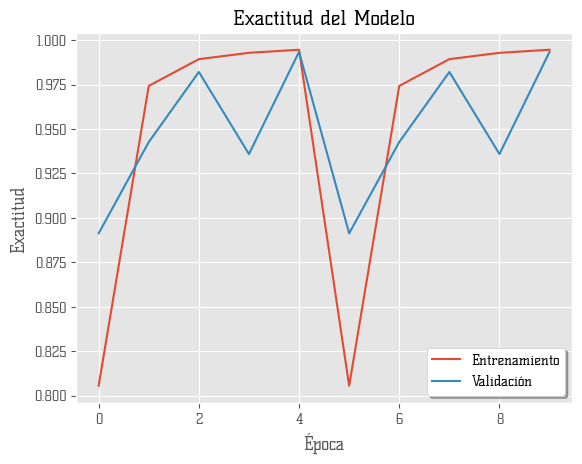

In [20]:
# Gráfico
plt.plot(history.history['accuracy'] + history.history['accuracy'])
plt.plot(history.history['val_accuracy'] + history.history['val_accuracy'])
plt.title('Exactitud del Modelo')
plt.ylabel('Exactitud')
plt.xlabel('Época')
plt.legend(['Entrenamiento', 'Validación'], loc='best', fancybox=True, shadow=True, facecolor='white')
plt.grid(True)
plt.show()

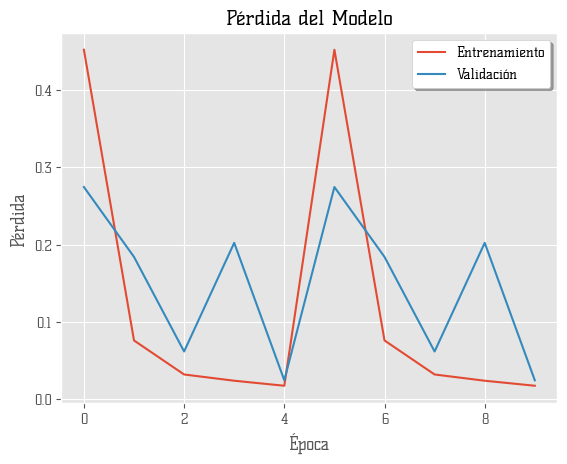

In [24]:
plt.plot(history.history['loss'] + history.history['loss'])
plt.plot(history.history['val_loss'] + history.history['val_loss'])
plt.title('Pérdida del Modelo')
plt.ylabel('Pérdida')
plt.xlabel('Época')
plt.legend(['Entrenamiento', 'Validación'], loc='best', fancybox=True, shadow=True, facecolor='white')
plt.grid(True)
plt.show()

In [25]:
pred = model.predict(test)
pred = np.argmax(pred, axis=1)

labels = (train.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred2 = [labels[k] for k in pred]

319/319 ━━━━━━━━━━━━━━━━━━━━ 53s 157ms/step


In [31]:
from sklearn.metrics import confusion_matrix, accuracy_score

y_test = test_images.labels # set y_test to the expected output
print(classification_report(y_test, pred2))
print("Exactitud del modelo:","{:.2f}%".format(accuracy_score(y_test, pred2)*100))

                   precision    recall  f1-score   support

    Demencia Leve       0.99      1.00      1.00      2693
Demencia Moderada       1.00      1.00      1.00      1977
Demencia Muy Leve       0.99      0.99      0.99      2715
     Sin Demencia       1.00      0.99      0.99      2811

         accuracy                           1.00     10196
        macro avg       1.00      1.00      1.00     10196
     weighted avg       1.00      1.00      1.00     10196

Exactitud del modelo: 99.55%


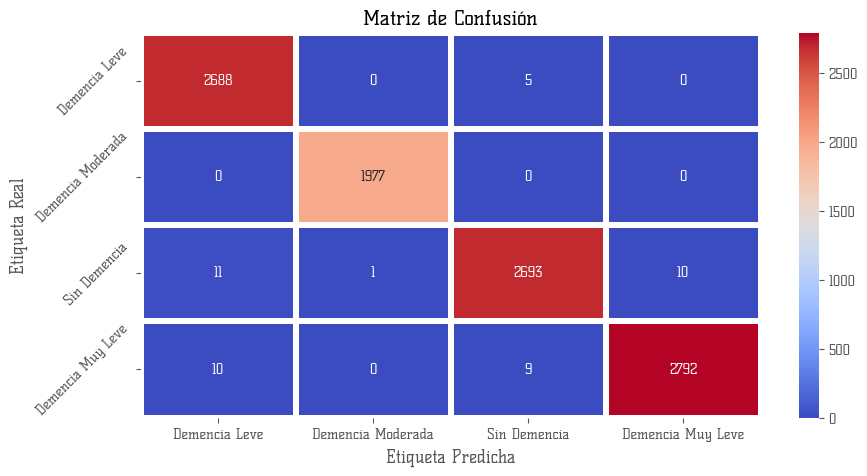

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Calcular matriz de confusión
cm = confusion_matrix(y_test, pred2)

plt.figure(figsize=(10, 5))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='coolwarm', linewidth=4.2, edgecolor='black')

plt.xticks(ticks=[0.5, 1.5, 2.5, 3.5], labels=class_labels)
plt.yticks(ticks=[0.5, 1.5, 2.5, 3.5], labels=class_labels)
plt.xlabel("Etiqueta Predicha")
plt.ylabel("Etiqueta Real")

# Hacer que las etiquetas no desborden en el eje y
plt.yticks(rotation=45)

plt.title("Matriz de Confusión")

# Mostrar matriz
plt.show()